# Dataiku Takehome assignment - Part 2 - EDA

## Background Information
The United States Census Bureau leads the country’s Federal Statistical System; its primary
responsibility is to collect demographic and economic data about America to help inform
strategic initiatives. Every ten years, the census is conducted to collect and organize information
regarding the US population with the intention of effectively allocating billions of dollars of
funding to various endeavors (e.g., the building and maintenance of hospitals, schools, fire
departments, transportation infrastructure, etc.). Additionally, the collection of census
information helps to examine the demographic characteristics of subpopulations across the
country.

## The Data
You have been provided a sample dataset from the US Census archive containing detailed, but
anonymized, information for ~300,000 individuals. This archive contains four files:
1. `census_income_learn.csv`
2. `census_income_test.csv`
3. `census_income_metadata.txt`
4. `census_income_additional_info.pdf (supplemental information)`

## The Task
For this technical assessment, you have been tasked with identifying **characteristics that are
associated with a person making more or less than $50,000 per year**; the target variable for
your research question is the final column of the datasets.


As the data scientist on this project, you are to attempt to answer this question by constructing a
data analysis/modeling pipeline. Code submissions should be in Python and making the solution
easily readable and replicable by the team will give you additional marks. In the event you would
like to use a different language or tool, please ask. Considerations for your data analysis should
include, but are not limited to, the following:
- Data Preparation: Data cleaning, preprocessing, feature engineering, etc., that may aid
in improving data clarity & model generation.
- **Exploratory Data Analysis: Numerical and/or graphical representations of the data that
may help inform insights and/or tactics for answering the research question of interest.**
- Data Modeling: The building of a few competing models to predict the target variable.
- Model Assessment: A selection of the best model based on performance comparisons.
- Results: A concise summary of key findings, recommendations, & future improvements.

# Research question
- What are the characteristics that are associated with a person making more or less than $50,000 per year?

In [143]:
import pandas as pd

In [144]:
train_data = pd.read_csv("./data/census_income_learn_processed.csv")

In [162]:
train_data.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [163]:
# Cast ADTIND (Industry code to categorical)
train_data["ADTIND"] = train_data["ADTIND"].apply(str)

In [164]:
train_data.shape # Shape of data

(199523, 42)

In [165]:
# Target distribution
train_data.target.value_counts(normalize = True)

target
- 50000.    0.937942
50000+.     0.062058
Name: proportion, dtype: float64

In [166]:
# numeric columns
numeric_columns = train_data.select_dtypes(exclude=['object']).columns

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

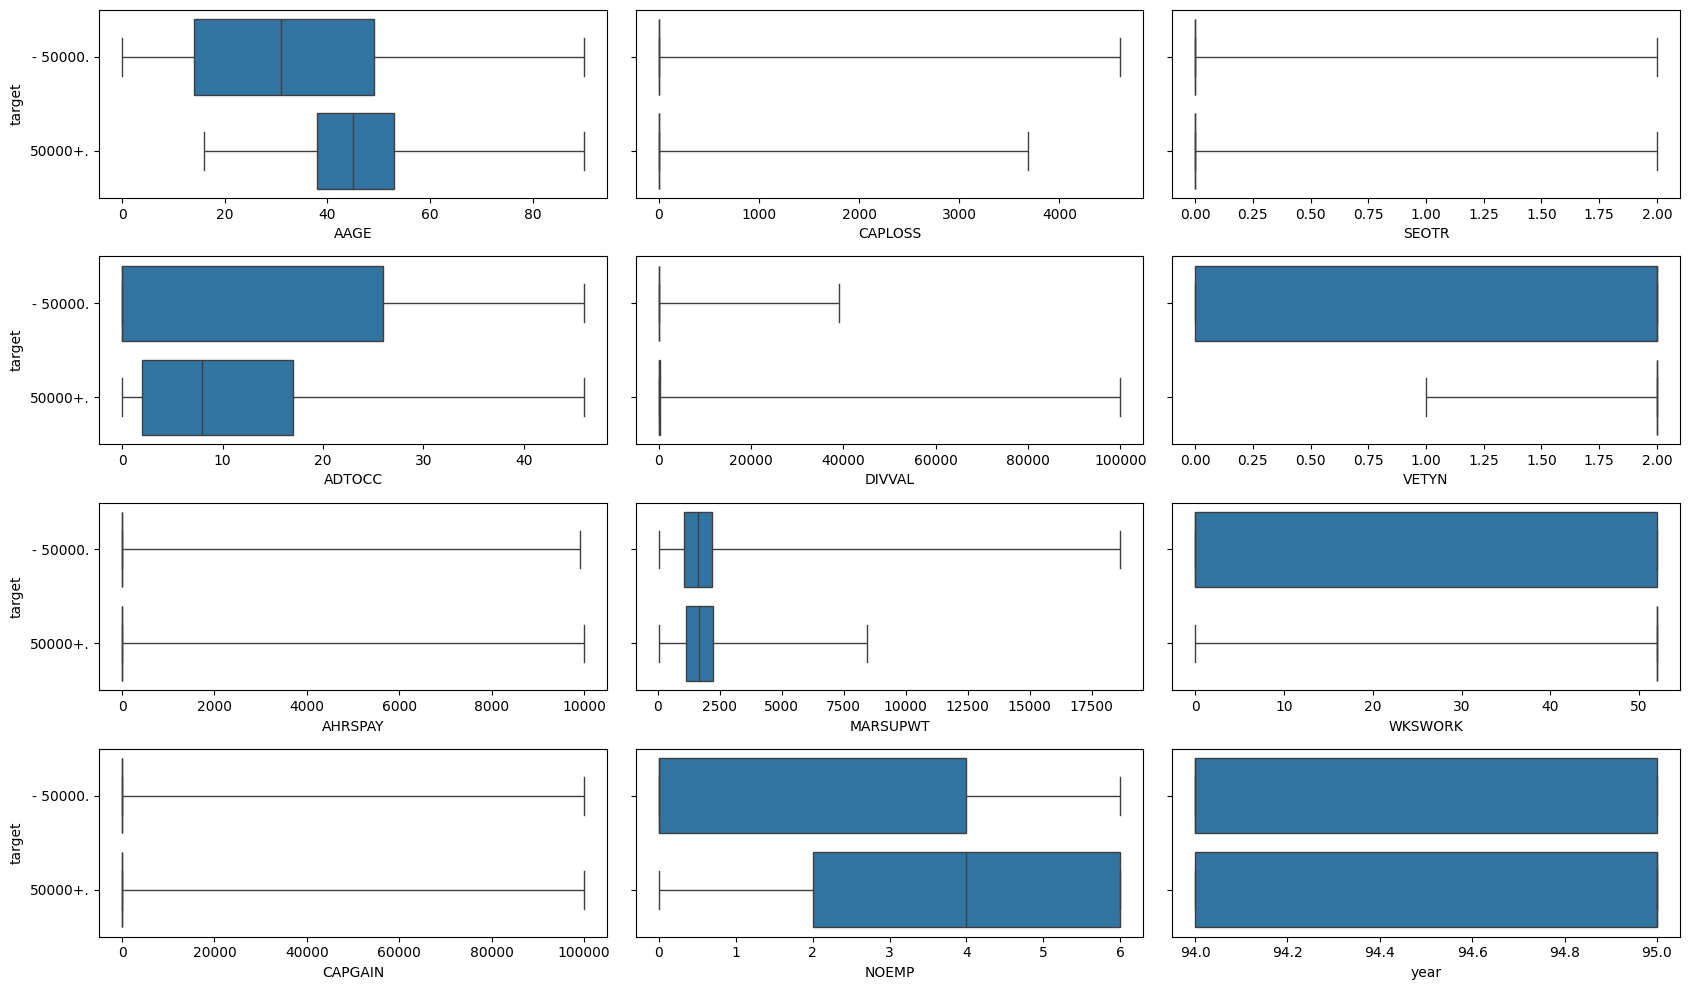

In [168]:
fig, ax = plt.subplots(4, math.ceil(len(numeric_columns) / 4),
                       figsize=(17, 10), sharey='all')
# Numerical columns - density plots
for i, column in enumerate(numeric_columns):
    sns.boxplot(
        train_data, x=column, y="target",
        whis=[0, 100],
        ax = ax[i % 4, math.floor(i/4)]
    )
plt.tight_layout()

In [169]:
# Categorical data columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

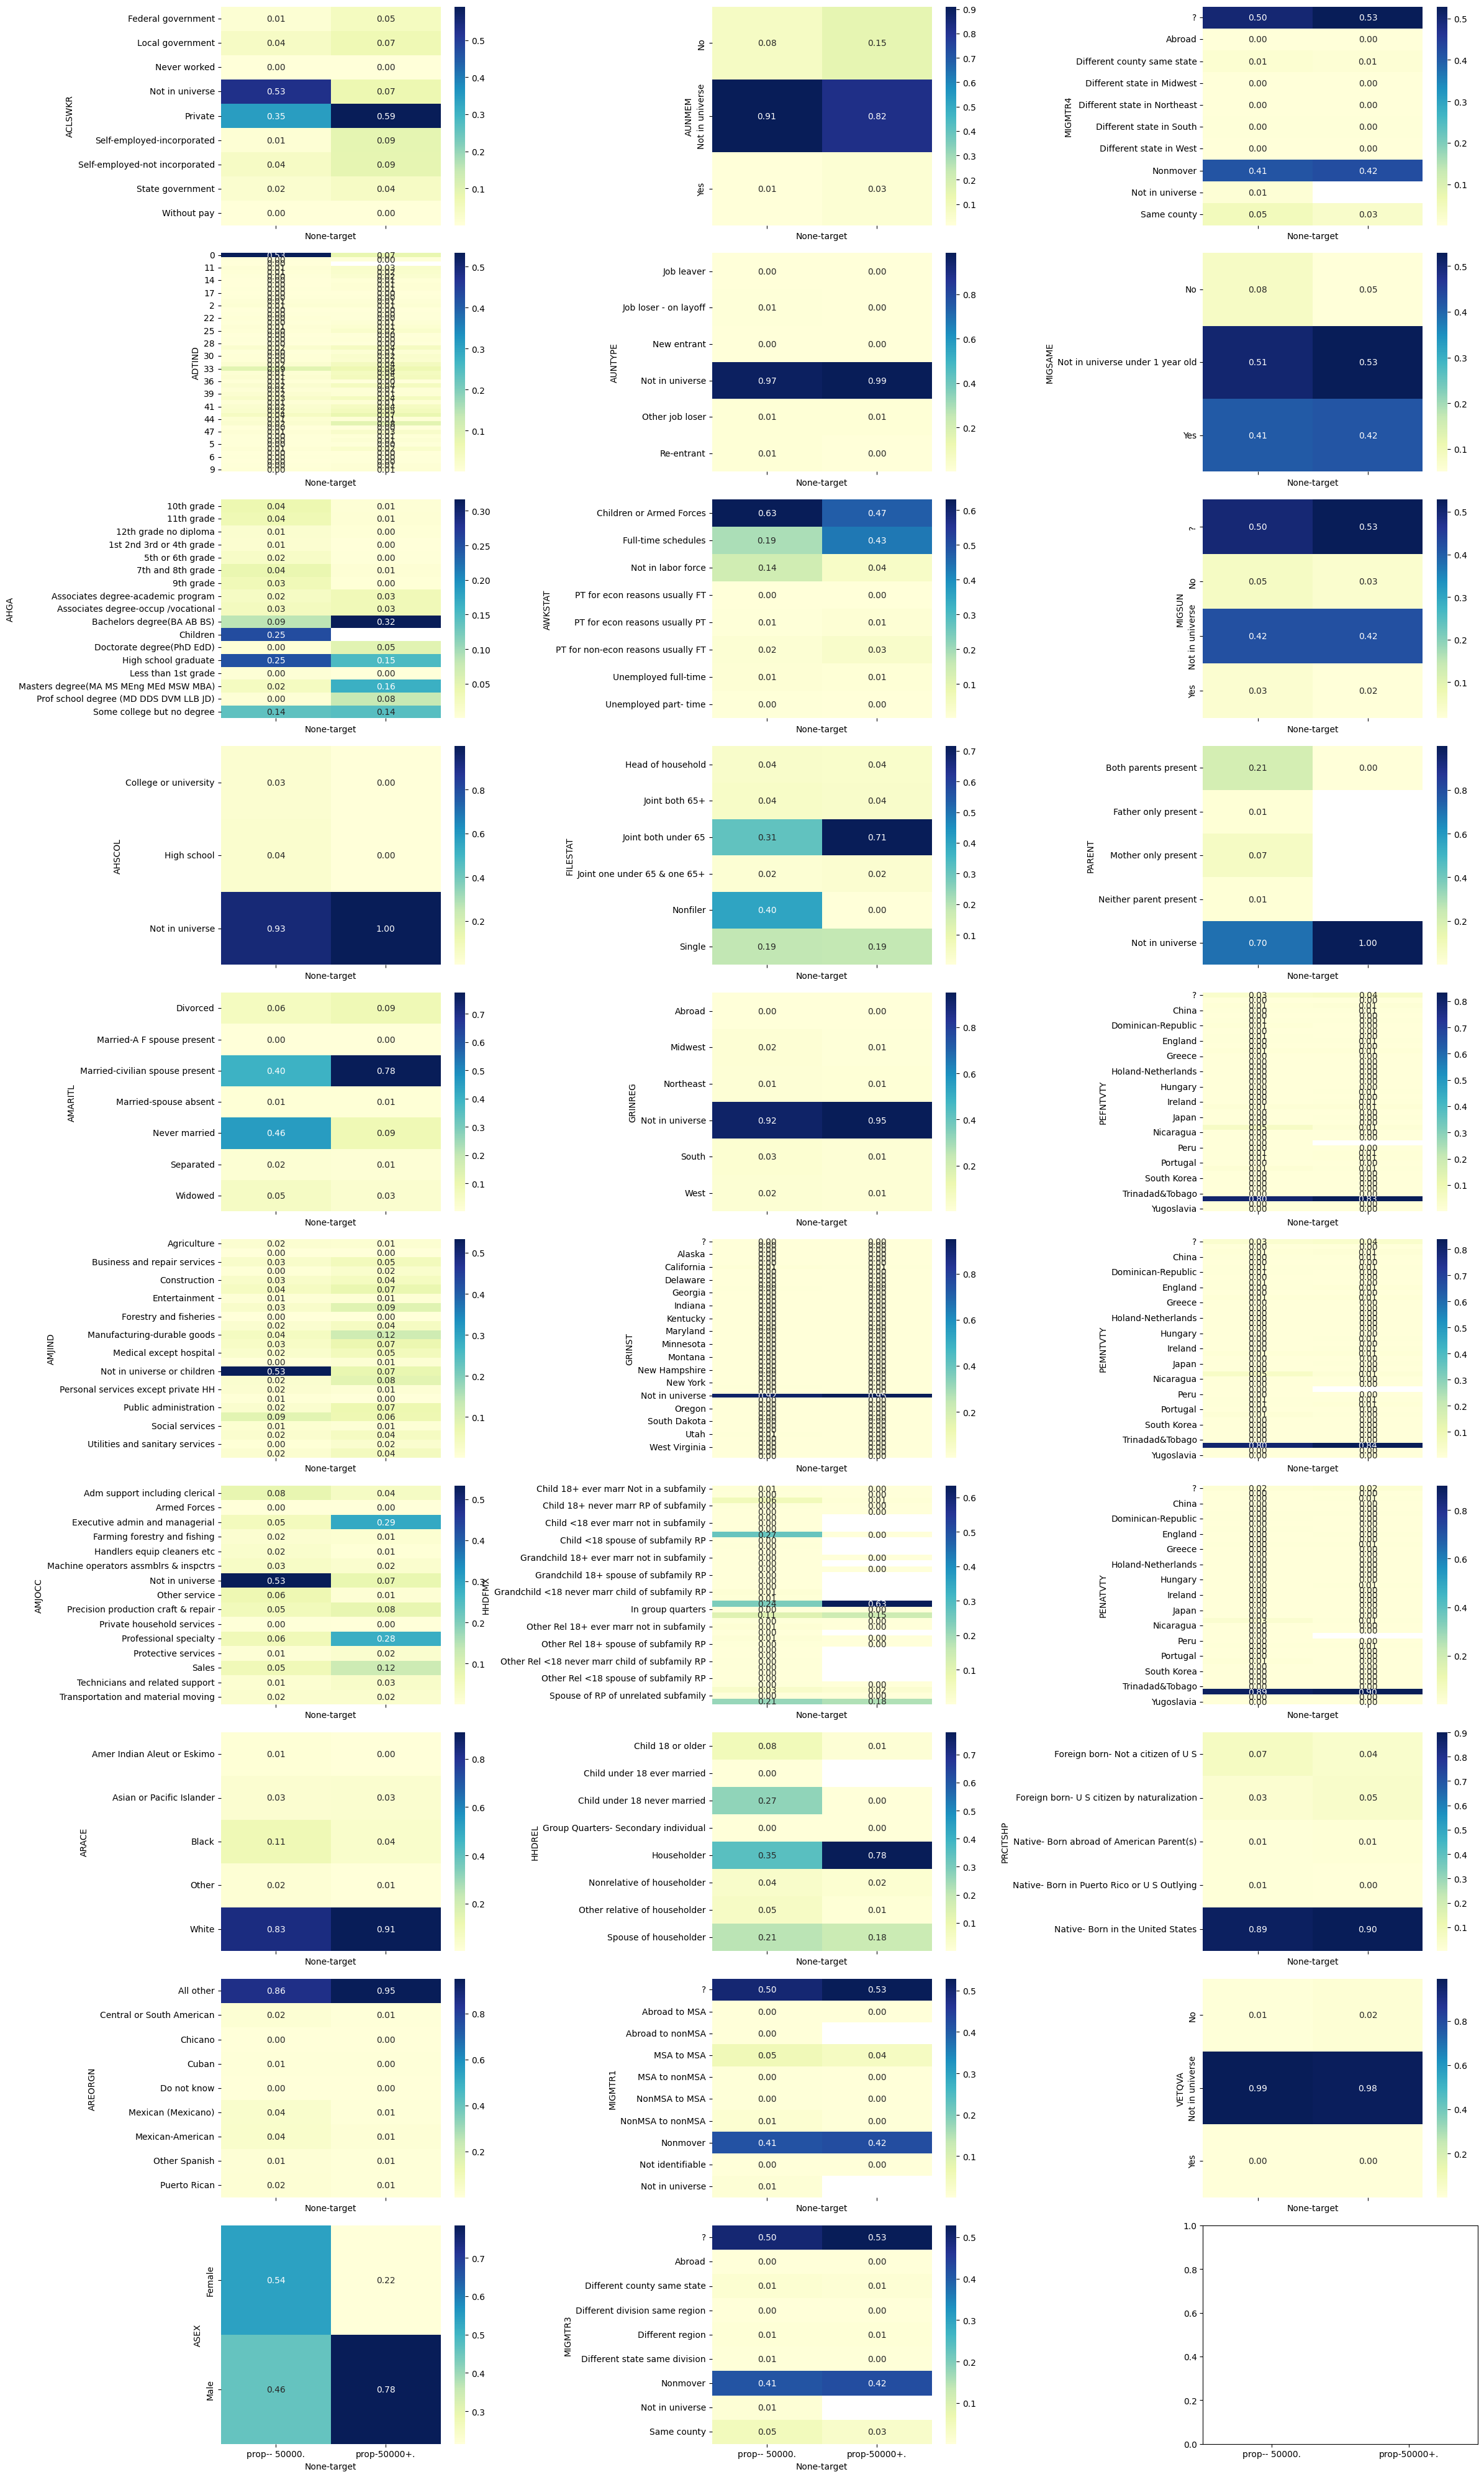

In [170]:
nrows = 10

fig, ax = plt.subplots(nrows, math.ceil(len(categorical_columns) / nrows),
                       figsize=(24, 40), sharex='all')
# Numerical columns - density plots
for i, column in enumerate(categorical_columns):

    if (column == 'target'):
        continue
    
    # Calculate proportion between groups
    prop = (train_data.groupby(["target", column])["target"].count() / train_data.groupby(["target"])["target"].count())
    prop = prop.reset_index(name='prop')

    # Plot heatmap
    sns.heatmap(prop.pivot(columns="target", index=column),
                cmap="YlGnBu",
                annot=True,
                fmt=".2f",
                ax = ax[i % nrows, math.floor(i/nrows)])
    
plt.tight_layout()

### Initial findings
- Continuous variables candidates:
    - AAGE  (AGE)
    - NOEMP (Num persons worked for employer)
    - VETYN (Veterans benefits)
    - WKSWORK (weeks worked in year)
- Cateogorical variables candidates:
    - Note: We have to be careful as there are heavy correlation between variables
    - Using tree-based model can handle multicollinearity
    - Variables that indicate working:
        - ACLSWKR (Class of worker)
        - ADTIND (Industry Code)
        - ADTOCC (Occupation Code)
        - AWKSTAT (Full or part tiem employment stat)
        - FILESTAT (Tax file status)
    - Variables about family structure
        - HHDFMX (Detailed household and family stat)
        - HHDREL (Detailed household summary in household)
        - PARENT (Family members under 18)
    - AHGA (Education)
    - AMARITL (Marital Status)
    - ARACE (Race)
    - ASEX (Sex)
- Variables that tell little information
    - MIGMTR1 (Migration code-change in msa)
    - MIGMTR3 (Migration code-change in reg)
    - MIGMTR4 (Migration code-move within reg)
    - MIGSAME (Live in this house 1 year ago
    - MIGSUN (Migration prev res in sunbelt)
    - PEFNTVTY (country of birth father)
    - PEMNTVTY (country of birth mother)
    - PENATVTY (country of birth self)
    - PRCITSHP (citizenship)
    - VETQVA (Fill inc questionnaire for veteran's admin)